<a href="https://colab.research.google.com/github/MicheleGiambelli/Deep-Learning-Project/blob/Matteo/Crypto_guru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import files
from torch import nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [36]:
ticker = "SOL-USD"
btc_ticker = "BTC-USD"

solana_data = yf.download(ticker, start="2020-04-10")
btc_data = yf.download(btc_ticker, start="2020-04-10")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:

# Ensure the columns are renamed every time this cell is run
solana_data = solana_data.rename(columns={"Adj Close": "SOL_Adj_Close"})
btc_data = btc_data.rename(columns={"Adj Close": "BTC_Adj_Close"})

# Unione dei dati
# Instead of selecting individual columns, use the renamed dataframes directly
df = pd.concat([solana_data, btc_data], axis=1)
df = df.dropna()

# Calcolo dei rendimenti giornalieri
df["SOL_Return"] = df["SOL_Adj_Close"].pct_change()
df["BTC_Return"] = df["BTC_Adj_Close"].pct_change()

# Funzione per calcolare Beta
def rolling_beta(df, window):
    cov = df["SOL_Return"].rolling(window).cov(df["BTC_Return"])
    var = df["BTC_Return"].rolling(window).var()
    return cov / var

# Define n before using it in rolling_beta
n = 20  # For example, a 20-day rolling window for beta calculation

# Aggiungere Beta
df["Beta"] = rolling_beta(df, n)
df = df.dropna()


In [38]:
n = 20  # Periodo per bande di Bollinger e Beta
k = 2  # Deviazioni standard per bande di Bollinger

# Calcolo Bande di Bollinger
df["SMA"] = df["SOL_Adj_Close"].rolling(window=n).mean()
df["StdDev"] = df["SOL_Adj_Close"].rolling(window=n).std()
df["Upper_Band"] = df["SMA"] + k * df["StdDev"]
df["Lower_Band"] = df["SMA"] - k * df["StdDev"]
df = df.dropna()


In [39]:
def rolling_sharpe_ratio(df, window, risk_free_rate):
    rolling_mean = df["SOL_Return"].rolling(window).mean()
    rolling_std = df["SOL_Return"].rolling(window).std()
    return (rolling_mean - risk_free_rate) / rolling_std
risk_free_rate = 0.01
# Aggiungere Sharpe Ratio
df["Sharpe_Ratio"] = rolling_sharpe_ratio(df, n, risk_free_rate)
df = df.dropna()


In [40]:
df.drop(df.columns[[6,7,8,9,10,11,13]], axis=1, inplace=True) # tolgo le colonne relative a BTC che non mi servono
df.head()

Price,SOL_Adj_Close,Close,High,Low,Open,Volume,SOL_Return,Beta,SMA,StdDev,Upper_Band,Lower_Band,Sharpe_Ratio
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,,,
Date,,,,,,,,,,,,,
2020-06-07,0.616578,0.616578,0.624444,0.593398,0.622443,716785,-0.009423,0.427358,0.595371,0.027581,0.650533,0.540209,-0.201951
2020-06-08,0.668313,0.668313,0.679001,0.613310,0.615078,1440234,0.083907,0.428930,0.597564,0.031483,0.660529,0.534599,-0.085599
2020-06-09,0.658002,0.658002,0.668088,0.627242,0.667784,988327,-0.015428,0.346123,0.601506,0.033900,0.669306,0.533706,-0.038440
2020-06-10,0.644867,0.644867,0.670043,0.633404,0.658038,1096203,-0.019962,0.524364,0.603304,0.035240,0.673784,0.532823,-0.103663
2020-06-11,0.573742,0.573742,0.650535,0.570082,0.644888,1122221,-0.110294,0.739265,0.600047,0.034787,0.669620,0.530474,-0.229623


# DEA

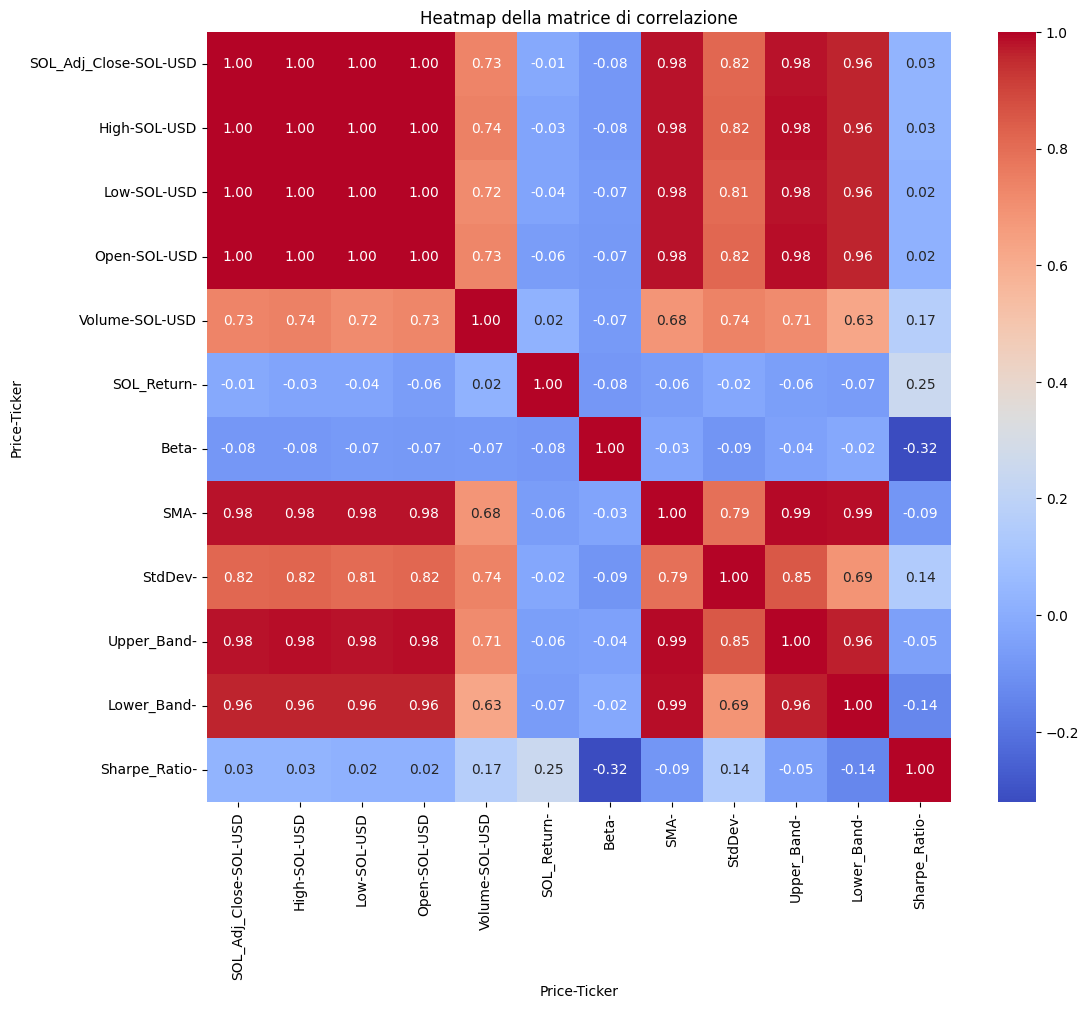

Variance Inflation Factor (VIF):
                    Variable          VIF
7                    (SMA, )          inf
8                 (StdDev, )          inf
9             (Upper_Band, )          inf
10            (Lower_Band, )          inf
1            (High, SOL-USD)  1735.695123
0   (SOL_Adj_Close, SOL-USD)  1166.190931
3            (Open, SOL-USD)  1024.423484
2             (Low, SOL-USD)   942.014271
4          (Volume, SOL-USD)     4.490770
11          (Sharpe_Ratio, )     1.832428
5             (SOL_Return, )     1.739225
6                   (Beta, )     1.164277


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [41]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

# Rimozione dei valori NaN per analisi pulita
df_sol_clean = df.dropna()

# Gestione del MultiIndex: rimuovi la variabile target specificando entrambi i livelli
target_var = ('Close', 'SOL-USD')  # Nome esatto della variabile nel MultiIndex
independent_vars = [col for col in df_sol_clean.columns if col != target_var]

# Matrice di correlazione
correlation_matrix = df_sol_clean[independent_vars].corr()

# Visualizzazione della matrice di correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap della matrice di correlazione")
plt.show()

# Calcolo del VIF
X = df_sol_clean[independent_vars]
X_with_const = sm.add_constant(X)  # Aggiungi la costante per il calcolo del VIF

vif_data = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X_with_const.values, i + 1) for i in range(X.shape[1])]
}).sort_values(by="VIF", ascending=False)

# Mostra i risultati del VIF
print("Variance Inflation Factor (VIF):")
print(vif_data)

# Suggerimento: Rimuovi o combina variabili con VIF molto elevato.


**Indago la linearità**

Nel secondo grafico ho messo solo le variabili che secondo me ha senso includere nella regressione, ho tolto:
-Lower/Upper band, più che altro perché dipendono strettamente dalla media mobile (SMA) e quindi non ha senso metterle se già c’è SMA altrimenti avrebbero una collinearità molto alta.
-prezzo di apertura (open) perché è come se utilizzassimo close 2 volte per titolo (il prezzo di apertura del giorno dopo è quello di chiusura del giorno prima).

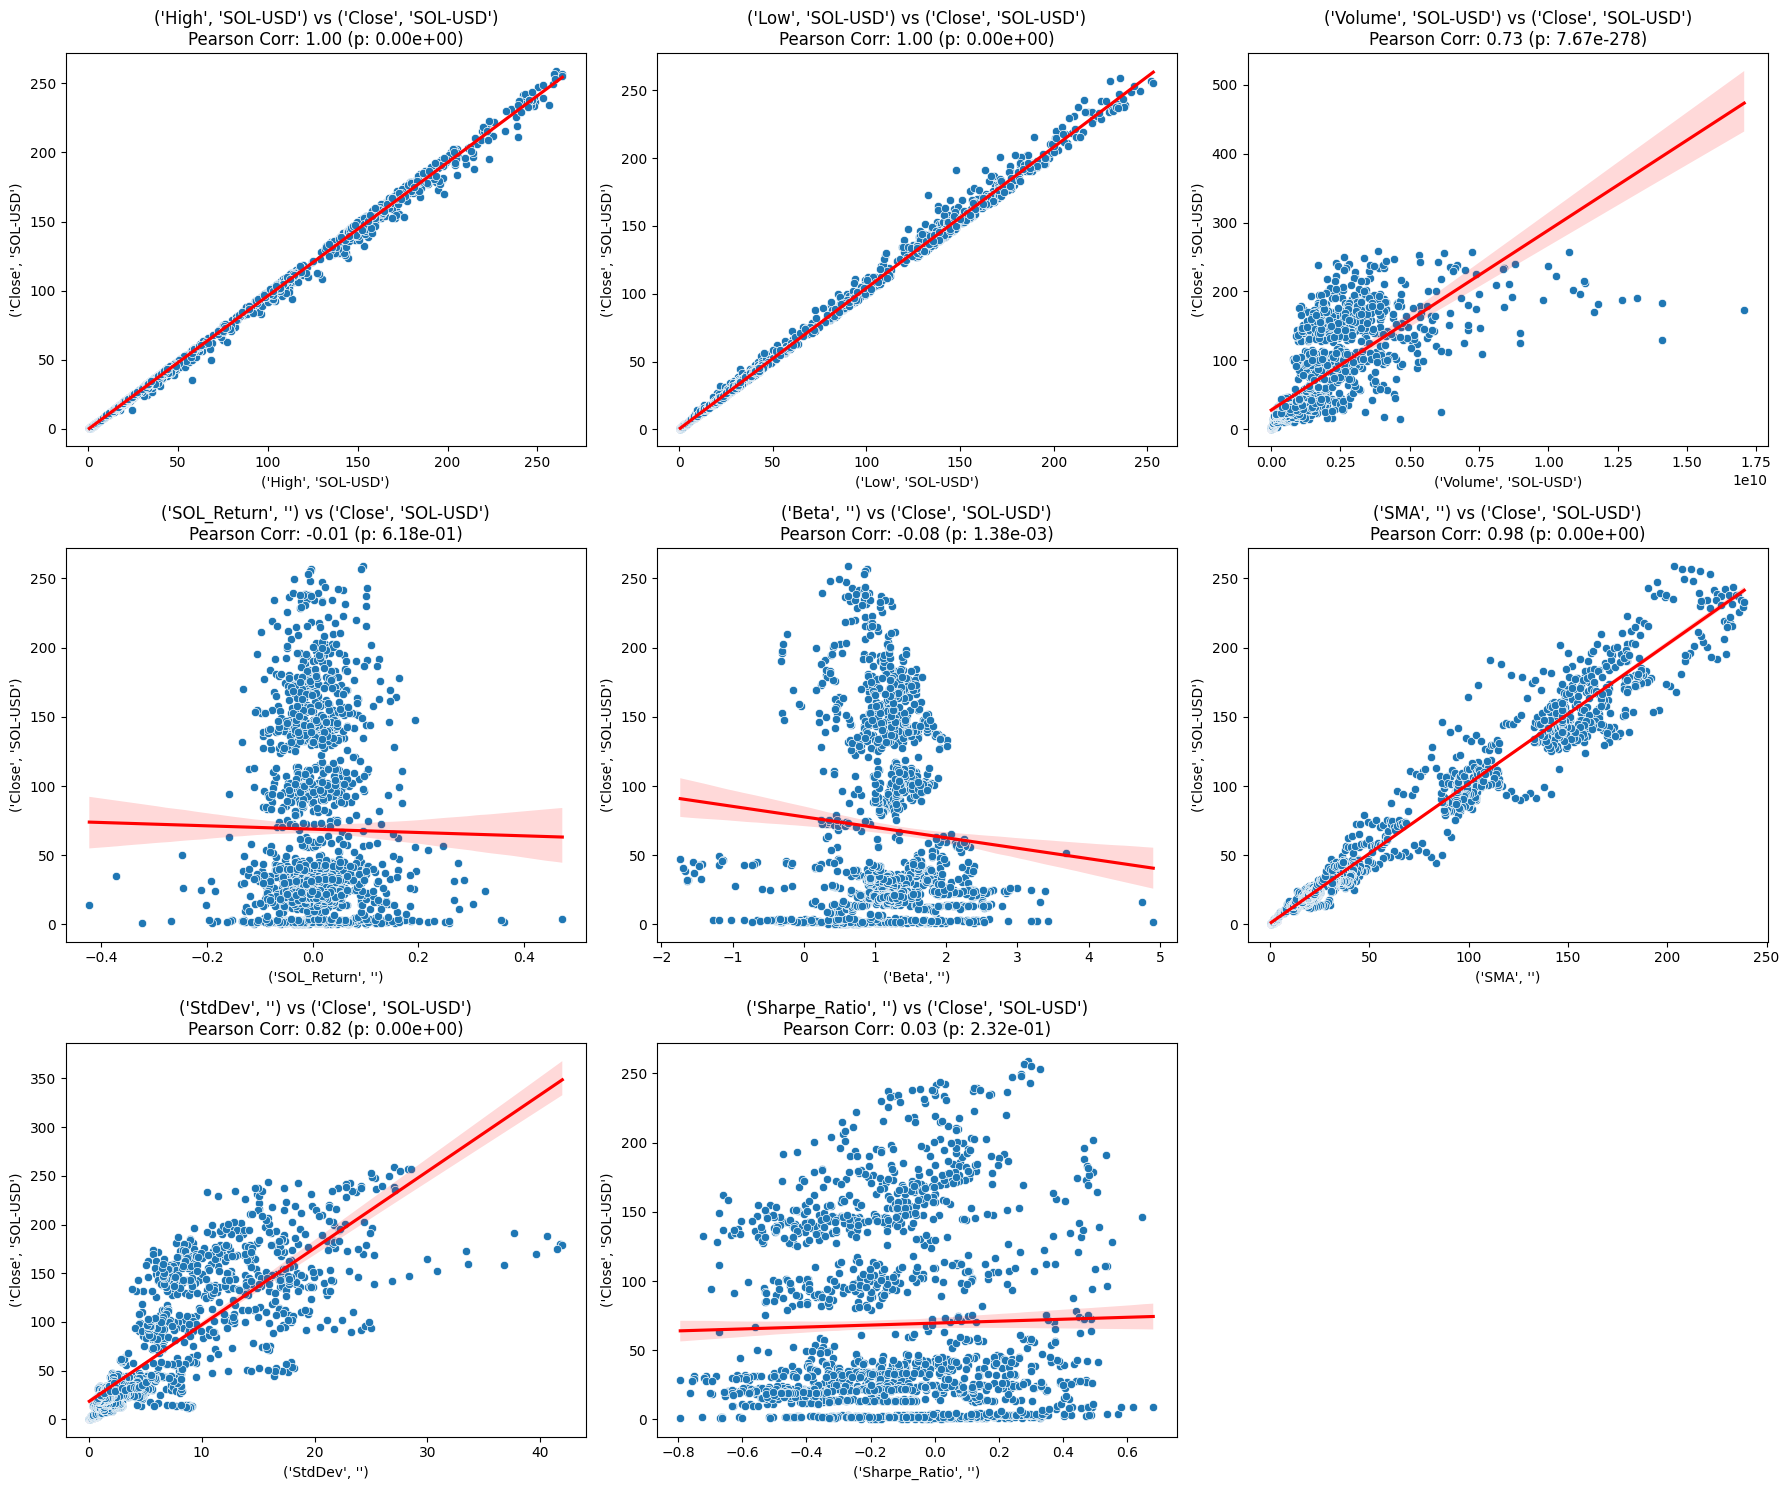

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Variabile dipendente
dependent_var = ('Close', 'SOL-USD')

# Lista delle variabili indipendenti (con MultiIndex)
independent_vars = [

    ('High', 'SOL-USD'),
    ('Low', 'SOL-USD'),
    ('Volume', 'SOL-USD'),
    ('SOL_Return', ''),
    ('Beta', ''),
    ('SMA', ''),
    ('StdDev', ''),
    ('Sharpe_Ratio', '')
]

# Filtra le variabili disponibili
available_vars = [var for var in independent_vars if var in df.columns]

# Rimuovi righe con NaN nelle variabili di interesse
df_filtered = df.dropna(subset=[dependent_var] + available_vars)

# Configurazione della griglia dei grafici
n_cols = 3  # Numero di colonne nella griglia
n_rows = -(-len(available_vars) // n_cols)  # Numero di righe necessario (ceil)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Scatter plot e analisi di linearità
for i, var in enumerate(available_vars):
    ax = axes[i]
    sns.scatterplot(x=df_filtered[var], y=df_filtered[dependent_var], ax=ax)
    sns.regplot(x=df_filtered[var], y=df_filtered[dependent_var], scatter=False, color='red', ax=ax)

    # Calcolo del coefficiente di correlazione
    corr, p_value = pearsonr(df_filtered[var], df_filtered[dependent_var])
    ax.set_title(f"{var} vs {dependent_var}\nPearson Corr: {corr:.2f} (p: {p_value:.2e})")
    ax.set_xlabel(var)
    ax.set_ylabel(dependent_var)

# Nascondi assi vuoti nella griglia
for j in range(len(available_vars), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [43]:
# modifico il dataframe con le nuove covariate

# Rimuoviamo le colonne specificate dal DataFrame
columns_to_drop = [('SOL_Adj_Close', 'SOL-USD'), ('Open', 'SOL-USD'), ('Upper_Band', ''), ('Lower_Band', '')]

# Creazione del nuovo DataFrame
df = df.drop(columns=columns_to_drop)
df.head()

Price,Close,High,Low,Volume,SOL_Return,Beta,SMA,StdDev,Sharpe_Ratio
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,
Date,,,,,,,,,
2020-06-07,0.616578,0.624444,0.593398,716785,-0.009423,0.427358,0.595371,0.027581,-0.201951
2020-06-08,0.668313,0.679001,0.613310,1440234,0.083907,0.428930,0.597564,0.031483,-0.085599
2020-06-09,0.658002,0.668088,0.627242,988327,-0.015428,0.346123,0.601506,0.033900,-0.038440
2020-06-10,0.644867,0.670043,0.633404,1096203,-0.019962,0.524364,0.603304,0.035240,-0.103663
2020-06-11,0.573742,0.650535,0.570082,1122221,-0.110294,0.739265,0.600047,0.034787,-0.229623


**<h1>Pytorch Dataset</h1>**

### Description of the Code below

This code demonstrates how to preprocess a dataset stored in a Pandas DataFrame and transform it into a format suitable for use with PyTorch, while ensuring the data can be efficiently loaded in batches for training or inference.

1. **Feature and Target Definition**:
   - The column `Close` is chosen as the target variable (`y`), representing the Solana price.
   - The remaining columns are used as the feature set (`X`).

2. **Feature Normalization**:
   - The features are scaled using `StandardScaler` from `sklearn` to ensure they have zero mean and unit variance. This helps improve the stability and convergence of training neural networks.

3. **Conversion to PyTorch Tensors**:
   - The normalized features (`X`) are converted into a PyTorch tensor of type `torch.float32`.
   - The target (`y`) is similarly converted into a tensor, reshaped to have a shape of `(-1, 1)` to align with PyTorch's supervised learning expectations.

4. **Custom DataLoader Function**:
   - A function, `load_array`, is defined to create a PyTorch `DataLoader`. This function:
     - Accepts `data_arrays` (a tuple of feature and target tensors).
     - Uses unpacking (`*data_arrays`) to pass the tensors dynamically to `TensorDataset`.
     - Returns a `DataLoader` with a specified batch size.
     - Includes the `is_train` parameter to control whether data shuffling is enabled. Here, it defaults to `False` to maintain the historical order of the data.

5. **Batch Loading**:
   - The tensors for features (`X_tensor`) and target (`y_tensor`) are packed into a tuple `data_arrays`.
   - A `DataLoader` is created with a batch size of 32, ensuring that the data is processed in manageable chunks.

This code is well-suited for historical data processing (e.g., time-series or financial data) where the order of data is important, thanks to the use of `shuffle=False`. The preprocessing ensures the dataset is ready for efficient model training or evaluation in PyTorch.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Assume your DataFrame pandas is named `df`
# Define 'Close' as the target and the rest as features
X = df.drop(columns=['Close'], level = 0).values  # Features
y = df['Close'].values  # Target

# Normalize the features, referring to the same numerical scale
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
y_normalized = scaler.fit_transform(y.reshape(-1, 1))

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_normalized, dtype=torch.float32)

# Create sequences
sequence_length = 5
X_sequences = []
y_sequences = []

for i in range(len(X_normalized) - sequence_length):
    X_seq = X_normalized[i:i + sequence_length]
    y_seq = y[i + sequence_length]
    X_sequences.append(X_seq)
    y_sequences.append(y_seq)

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

X_tensor = torch.tensor(X_sequences, dtype=torch.float32)
y_tensor = torch.tensor(y_sequences, dtype=torch.float32)

# Suddivisione in training e validation set
# Suddivisione temporale del dataset
n = len(X_tensor)

# Percentuali di suddivisione
train_split = int(n * 0.7)  # Prime 70% osservazioni per il training
val_split = int(n * 0.9)    # Successive 20% osservazioni per la validation
test_split = n              # Ultime 10% osservazioni per il test

train_dataset = (X_tensor[:train_split], y_tensor[:train_split])
val_dataset = (X_tensor[train_split:val_split], y_tensor[train_split:val_split])
test_dataset = (X_tensor[val_split:test_split], y_tensor[val_split:test_split])

# Define a function for loading data with unpacking
def load_array(data_arrays, batch_size, is_train=False): # False because we want to read the data historically
    """Construct a PyTorch DataLoader."""
    dataset = TensorDataset(*data_arrays)  # Unpacking the tensors
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

# Create the DataLoader
data_arrays = (X_tensor, y_tensor)  # Pack tensors into a tuple
batch_size = 32
train_loader = load_array(train_dataset, batch_size)
valid_loader = load_array(val_dataset, batch_size)
test_loader = load_array(test_dataset, batch_size)


In [ ]:

batch_X, batch_y = next(iter(train_loader))
print(batch_X.shape)  # Expected: torch.Size([32, 10, 12])
print(batch_y.shape)

torch.Size([32, 5, 12])
torch.Size([32, 1])


# LSTM

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Stato nascosto iniziale e stato della cella
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Passaggio attraverso la LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Passaggio attraverso il layer fully connected
        out = self.fc(out[:, -1, :])  # Usare solo l'ultimo stato nascosto
        return out

In [ ]:
import torch.optim as optim

# Iperparametri
input_size = 12
hidden_size = 100
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 500

# Inizializzazione del modello, della loss function e dell'optimizer
model = LSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

In [ ]:
# Addestramento del modello
from sklearn.metrics import mean_absolute_error



model.train()
for epoch in range(num_epochs):
    if early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    model.train()
    train_loss = 0.0
    train_mae = 0.0

    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass e aggiornamento dei pesi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calcolo del MAE
        predictions = scaler.inverse_transform(outputs.detach().numpy())  # Denormalizza le predizioni
        actuals = scaler.inverse_transform(batch_y.numpy())  # Denormalizza i target
        train_mae += mean_absolute_error(actuals, predictions)

    train_loss /= len(train_loader)
    train_mae /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_mae = 0.0

    with torch.no_grad():
        for val_X, val_y in valid_loader:
            val_outputs = model(val_X)
            loss = criterion(val_outputs, val_y)
            val_loss += loss.item()

            # Calcolo del MAE per il validation set
            val_predictions = scaler.inverse_transform(val_outputs.numpy())
            val_actuals = scaler.inverse_transform(val_y.numpy())
            val_mae += mean_absolute_error(val_actuals, val_predictions)

    val_loss /= len(valid_loader)
    val_mae /= len(valid_loader)

    # Stampa della loss e del MAE ogni 10 epoche
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

# Early stopping check
    if val_loss < best_loss:
      best_loss = val_loss
      epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= 5:
        early_stop = True

Epoch [10/500], Train Loss: 3789.1284, Train MAE: 2407.5544, Val Loss: 8129.1812, Val MAE: 4803.1611
Epoch [20/500], Train Loss: 2908.5642, Train MAE: 1749.9305, Val Loss: 6209.0174, Val MAE: 4059.2036
Epoch [30/500], Train Loss: 2290.4158, Train MAE: 1468.3663, Val Loss: 4661.7087, Val MAE: 3423.8397
Epoch [40/500], Train Loss: 1809.7735, Train MAE: 1248.7424, Val Loss: 3476.6064, Val MAE: 2847.1034
Epoch [50/500], Train Loss: 1444.5264, Train MAE: 1112.9607, Val Loss: 2577.4150, Val MAE: 2374.5808
Epoch [60/500], Train Loss: 1158.6226, Train MAE: 949.5937, Val Loss: 1910.1751, Val MAE: 2000.6216
Epoch [70/500], Train Loss: 949.8147, Train MAE: 842.3494, Val Loss: 1407.8226, Val MAE: 1615.2327
Epoch [80/500], Train Loss: 766.9320, Train MAE: 720.8682, Val Loss: 1036.7162, Val MAE: 1356.5726
Epoch [90/500], Train Loss: 629.9771, Train MAE: 678.4575, Val Loss: 772.9062, Val MAE: 1216.2735
Epoch [100/500], Train Loss: 508.0381, Train MAE: 577.1900, Val Loss: 545.1338, Val MAE: 965.6153
E

In [ ]:
# Valutazione finale
X_test, y_test = next(iter(train_loader))
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions = scaler.inverse_transform(predictions)  # Denormalizza
    actuals = scaler.inverse_transform(y_test.numpy())

# Output delle performance
print("Predizioni vs Valori Reali")
print(np.concatenate((predictions[:10], actuals[:10]), axis=1))  # Mostra i primi 10 risultati

Predizioni vs Valori Reali
[[191.22493  108.09262 ]
 [206.18579  109.09048 ]
 [227.57782  107.64301 ]
 [217.63666  106.55487 ]
 [213.11868  107.543655]
 [213.39114  107.27794 ]
 [214.58461  109.885704]
 [232.71976  114.08101 ]
 [252.4463   111.38407 ]
 [230.08275  113.34073 ]]


Il formato del tensore torch.Size([32, 12]) che ottieni con next(iter(data_loader))[0].shape è parzialmente corretto per creare una LSTM, ma manca una dimensione fondamentale: la dimensione di sequenza temporale.

Per una LSTM, il tensore di input dovrebbe avere la seguente forma:

(
batch_size
,
sequence_length
,
input_size
)
(batch_size,sequence_length,input_size)

Spesso la scelta di sequence_length viene fatta sperimentalmente:

Prova diversi valori (ad esempio, 1, 5, 7) e confronta le prestazioni del modello (ad esempio, tramite metriche come MSE o MAE).
Usa la validazione incrociata per capire quale valore produce le previsioni più accurate.
